In [ ]:
# %%
"""
# NMME Temperature Observations to Avoid Loggerheads (TOTAL)
 
The script calculate the TOTAL value from the start of the nmme 1991 based on 
Brodie et al., [2023]

Using NMME model hindcast and forecast obtained from 
http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/
with variable SST

"""


# %%
# start a local cluster
import json
import subprocess
from datetime import date
import warnings
import numpy as np
import xarray as xr
from dask.distributed import Client
from nmme_download import iri_nmme_models
from nmme_hci_climo_threshold import read_marine_index_mask
from nmme_monthly_mhw import read_nmme_onlist
from nmme_hci_monthly import output_format





warnings.filterwarnings("ignore")

### open local cluster
client = Client(processes=False)
print(client)
print(client.cluster.dashboard_link)

###### Setting ######
# specify date
today = date.today()
# setup the new output file name (same as date of download)
dateform = today.strftime("%y_%m_%d")

# directory where new simulation (inputs) and mhw forecast (outputs) is located
BASEDIR = '/Datasets.private/marinehw/nmme_sst_raw/'

# directory where sst threshold/climatology/trend (inputs) is located
PREDIR = '/Datasets.private/marinehw/nmme_sst_stat/'

# directory where nmme mhw probability is located
OUTDIR = '/Datasets.private/marinehw/nmme_mhw_prob/'

# directory where the marine index mask is located
MASKDIR = '/Datasets.private/marinehw/nmme_marine_index_mask/'

# output filename date, MHW prediction generated date
date = dateform

# used model list
with open('model_use_list.json','r',encoding='utf-8') as f:
    json_dict = json.load(f)
model_use_list = json_dict['model_use_list']

dict_model = iri_nmme_models()
avai_model_list = list(dict_model.keys())

 

<Client: 'inproc://10.173.16.4/1396827/1' processes=1 threads=96, memory=0.98 TiB>
http://10.173.16.4:8787/status


In [ ]:
################################## Main program start #####################################

dict_da = read_nmme_onlist(model_use_list,avai_model_list,BASEDIR,PREDIR,start_year=1991,lazy=False)

ds_mask = read_marine_index_mask(MASKDIR)




In [ ]:
da_total_identified_list = []
da_total_all_list = []
for nmodel,model in enumerate(model_use_list):
    if model in avai_model_list:
        threshold_file = f'{PREDIR}{model}_climo_threshold_total.nc'

        print('------------')
        print(model,' TOTAL detection...')
        print('------------')

        # read threshold (1991-2020)
        da_threshold = xr.open_dataset(
            threshold_file,
            chunks={'S':1,'L':1}
        )['total_threshold']

        da_ssta = ds_mask['TOTAL']*(
            dict_da['da_model_list'][nmodel].groupby('S.month')
            -dict_da['da_climo_list'][nmodel]
        )
        # calculate area weight
        weights = np.cos(np.deg2rad(da_ssta.Y))
        weights.name = "weights"
        # calculate area weighted mean
        da_ssta_areamean = da_ssta.weighted(weights).mean(dim=["X","Y"])

        # calculate the 6-month rolling mean of the previous six month
        da_total = da_ssta_areamean.rolling(L=6, center=False).mean()

        # the rolling mean of six month is put in the last month of the six
        #  shift 1 is needed to let the rolling mean represent the monthly
        #  value the is 1 month after the six month window
        da_total['L'] = da_total['L'].data+1.
        da_total = da_total.compute()

        da_total_all_list.append(da_total)
        # print('calculating TOTAL')
        # da_total_identified = da_total.where(da_total.groupby('S.month')>=da_threshold)
        # da_total_identified = (
        #     da_total_identified
        #     .where(da_total_identified.isnull(),other=1)
        #     .sum(dim=['M'],skipna=True)
        # ).compute()
        # da_total_all = (
        #     da_total
        #     .where(da_total.isnull(),other=1)
        #     .sum(dim=['M'],skipna=True)
        # ).compute()
        # da_total_identified_list.append(da_total_identified)
        # da_total_all_list.append(da_total_all)

        # del da_total

# total identified events higher than threshold (all ensemble and models)
da_total_concat = xr.concat(da_total_all_list,dim='model',join='outer')

------------
CanCM4i-IC3  TOTAL detection...
------------
------------
GEM5-NEMO  TOTAL detection...
------------
------------
GFDL-SPEAR-regridded  TOTAL detection...
------------
------------
NASA-GEOSS2S  TOTAL detection...
------------
------------
COLA-RSMAS-CCSM4  TOTAL detection...
------------
------------
COLA-RSMAS-CESM1  TOTAL detection...
------------
------------
NCEP-CFSv2  TOTAL detection...
------------


In [ ]:
da_total_mmm = da_total_concat.mean(dim='M').mean(dim='model')

In [ ]:
da_total_mmm

<xarray.DataArray (L: 12, S: 402)> Size: 19kB
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-0.23032534, -0.19639868, -0.20356219, ..., -0.25555602,
        -0.24574153, -0.283293  ],
       [-0.27987894, -0.17119126, -0.19888237, ..., -0.22802147,
        -0.21900359, -0.14399931],
       [-0.28010297, -0.18050942, -0.20452574, ..., -0.23418775,
        -0.18992808, -0.11273707]], dtype=float32)
Coordinates:
  * S        (S) object 3kB 1991-01-01 00:00:00 ... 2024-06-01 00:00:00
  * L        (L) float32 48B 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 12.5
    month    (S) int64 3kB 1 2 3 4 5 6 7 8 9 10 11 ... 8 9 10 11 12 1 2 3 4 5 6

In [ ]:
da_total_mmm = da_total_mmm.rename({'S':'start_time','L':'lead_time'})

6.5
8.5
11.5


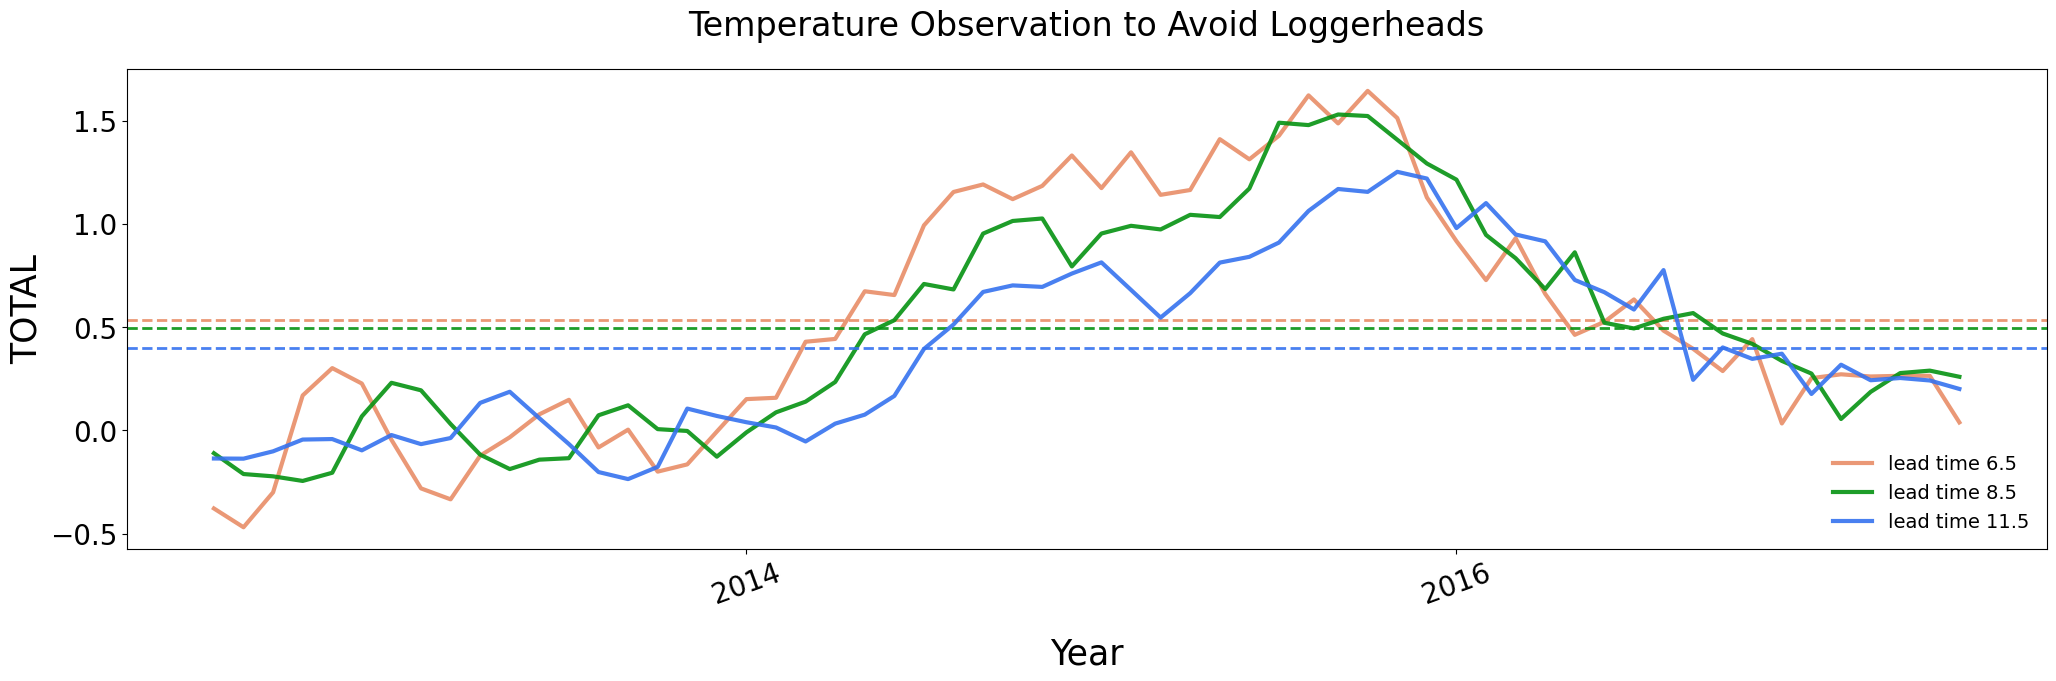

In [ ]:
import matplotlib.pyplot as plt
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])
lead_time = [6.5,8.5,11.5]
colors = ['#E88D67','#059212','#3572EF']

for nlead,leadtime in enumerate(lead_time):
    print(leadtime)
    time = da_total_mmm.sel(start_time=slice('2012-07','2017-06')).start_time.data
    da_total = da_total_mmm.sel(lead_time=leadtime)
     
    if leadtime == 6.5:
        da_total = da_total.sel(start_time=slice('2012-07','2017-06'))
    elif leadtime == 8.5:
        da_total = da_total.sel(start_time=slice('2012-05','2017-04'))
    elif leadtime == 11.5:
        da_total = da_total.sel(start_time=slice('2012-02','2017-01'))
    da_total['start_time'] = time

    (
    da_total
    .plot(
        color=colors[nlead],
        linestyle='solid',
        linewidth=3,
        ax=ax1,
        label=f'lead time {leadtime}',
        alpha=0.9,
    )
    )

    mean = (
    da_total
    .mean('start_time')
    )
    ax1.axhline(
        y=mean,
        linestyle='dashed',
        linewidth=2,
        alpha=0.9,
        color=colors[nlead],
    )


    #### setting the plotting format
    ax1.set_ylabel('TOTAL',{'size':'25'},color='k')
    ax1.tick_params(axis='y',labelsize=20,labelcolor='k')
    ax1.tick_params(axis='x',labelsize=20,labelcolor='k',rotation=20)
    ax1.set_xlabel('Year',{'size':'25'},labelpad=20)
    # ax1.set_ylim([-0.1,1])
    ax1.set_title("Temperature Observation to Avoid Loggerheads",{'size':'24'},pad=24)
    ax1.legend(loc='lower right',fontsize=14,frameon=False)

In [1]:
import xarray as xr
ds_total = xr.open_dataset('/Datasets.private/marinehw/nmme_mhw_prob/nmme_total_latest.nc')

In [2]:
ds_total

<xarray.Dataset> Size: 23kB
Dimensions:            (lead_time: 12, start_time: 401)
Coordinates:
  * lead_time          (lead_time) float32 48B 0.5 1.5 2.5 3.5 ... 9.5 10.5 11.5
  * start_time         (start_time) datetime64[ns] 3kB 1991-01-01 ... 2024-05-01
Data variables:
    total_probability  (start_time, lead_time) float32 19kB ...
Attributes:
    title:      ['TOTAL probability derived from  CanCM4i-IC3', 'TOTAL probab...
    comment:    Derived at NOAA Physical Science Laboratory
    reference:  Brodie et al., 2023, https://doi.org/10.1038/s41467-023-43188-0

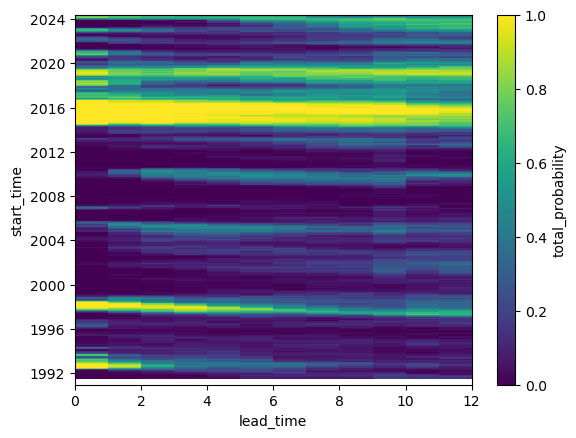

In [3]:
ds_total.total_probability.plot()